<a href="https://colab.research.google.com/github/davidsonsantana89/dass--CESAR_SCHOOL-Topicos_Contemporaneos/blob/main/projeto_final/desafio_1/dass_projeto_final_desafio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DAVIDSON ALVES SANTOS DE SANTANA

dass@cesar.school

In [185]:
import os
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import EfficientNet_V2_L_Weights
from torch.utils.data import DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!mkdir data

In [ ]:
# Baixa o dataset
!gdown 1UUCjRxIOcCGe6uHunqKZnDFkhaSMRnI4 -O data/pedestrian_no_pedestrian.zip

# Extrai o dataset
!unzip data/pedestrian_no_pedestrian.zip -d data

Downloading...
From: https://drive.google.com/uc?id=1UUCjRxIOcCGe6uHunqKZnDFkhaSMRnI4
To: /content/data/pedestrian_no_pedestrian.zip
100% 17.0M/17.0M [00:00<00:00, 19.2MB/s]
Archive:  data/pedestrian_no_pedestrian.zip
   creating: data/pedestrian_no_pedestrian/
   creating: data/pedestrian_no_pedestrian/train/
   creating: data/pedestrian_no_pedestrian/train/no pedestrian/
  inflating: data/pedestrian_no_pedestrian/train/no pedestrian/train (1).jpg  
  inflating: data/pedestrian_no_pedestrian/train/no pedestrian/train (10).jpg  
  inflating: data/pedestrian_no_pedestrian/train/no pedestrian/train (100).jpg  
  inflating: data/pedestrian_no_pedestrian/train/no pedestrian/train (101).jpg  
  inflating: data/pedestrian_no_pedestrian/train/no pedestrian/train (102).jpg  
  inflating: data/pedestrian_no_pedestrian/train/no pedestrian/train (103).jpg  
  inflating: data/pedestrian_no_pedestrian/train/no pedestrian/train (104).jpg  
  inflating: data/pedestrian_no_pedestrian/train/no pedestri

In [186]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_and_predict(model, image, class_names, device):
    model.to(device).eval()  # Certifique-se de que o modelo está no dispositivo correto
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # Converta predicted para um valor escalar
    predicted_index = predicted.item()

    # Verifique se predicted_index está dentro dos limites de class_names
    if predicted_index >= len(class_names) or predicted_index < 0:
        print(f"Índice de predição {predicted_index} está fora dos limites de class_names.")
        return

    # Normaliza a imagem entre 0 e 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted_index]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "data/pedestrian_no_pedestrian"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1
model = models.efficientnet_v2_l(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 216MB/s]


In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False


# Substituir a última camada
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

# Mover o modelo para o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)
print()

test_model(model, val_loader)

100%|██████████| 40/40 [00:05<00:00,  7.09it/s]


Epoch 1, Train Loss: 0.531, Train Accuracy: 72.98%
Epoch 1, Val Loss: 0.399, Val Accuracy: 84.75%


100%|██████████| 40/40 [00:05<00:00,  7.55it/s]


Epoch 2, Train Loss: 0.402, Train Accuracy: 82.09%
Epoch 2, Val Loss: 0.356, Val Accuracy: 86.16%


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Epoch 3, Train Loss: 0.377, Train Accuracy: 83.20%
Epoch 3, Val Loss: 0.360, Val Accuracy: 86.72%


100%|██████████| 40/40 [00:05<00:00,  7.55it/s]


Epoch 4, Train Loss: 0.365, Train Accuracy: 84.47%
Epoch 4, Val Loss: 0.416, Val Accuracy: 88.42%


100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Epoch 5, Train Loss: 0.378, Train Accuracy: 82.65%
Epoch 5, Val Loss: 0.308, Val Accuracy: 87.57%


100%|██████████| 40/40 [00:05<00:00,  7.53it/s]


Epoch 6, Train Loss: 0.350, Train Accuracy: 84.31%
Epoch 6, Val Loss: 0.334, Val Accuracy: 87.85%


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Epoch 7, Train Loss: 0.346, Train Accuracy: 85.10%
Epoch 7, Val Loss: 0.343, Val Accuracy: 87.01%


100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


Epoch 8, Train Loss: 0.361, Train Accuracy: 84.07%
Epoch 8, Val Loss: 0.313, Val Accuracy: 87.85%


100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Epoch 9, Train Loss: 0.337, Train Accuracy: 84.71%
Epoch 9, Val Loss: 0.349, Val Accuracy: 88.42%


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Epoch 10, Train Loss: 0.378, Train Accuracy: 83.52%
Epoch 10, Val Loss: 0.303, Val Accuracy: 87.01%


100%|██████████| 40/40 [00:05<00:00,  7.66it/s]


Epoch 11, Train Loss: 0.393, Train Accuracy: 84.55%
Epoch 11, Val Loss: 0.302, Val Accuracy: 88.14%


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


Epoch 12, Train Loss: 0.383, Train Accuracy: 83.99%
Epoch 12, Val Loss: 0.298, Val Accuracy: 87.01%


100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


Epoch 13, Train Loss: 0.337, Train Accuracy: 84.79%
Epoch 13, Val Loss: 0.295, Val Accuracy: 86.72%


100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


Epoch 14, Train Loss: 0.389, Train Accuracy: 84.55%
Epoch 14, Val Loss: 0.436, Val Accuracy: 87.57%


100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


Epoch 15, Train Loss: 0.334, Train Accuracy: 84.55%
Epoch 15, Val Loss: 0.338, Val Accuracy: 88.14%


100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


Epoch 16, Train Loss: 0.371, Train Accuracy: 84.63%
Epoch 16, Val Loss: 0.293, Val Accuracy: 88.42%


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Epoch 17, Train Loss: 0.353, Train Accuracy: 84.23%
Epoch 17, Val Loss: 0.292, Val Accuracy: 88.98%


100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


Epoch 18, Train Loss: 0.340, Train Accuracy: 85.50%
Epoch 18, Val Loss: 0.316, Val Accuracy: 88.70%


100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


Epoch 19, Train Loss: 0.364, Train Accuracy: 84.23%
Epoch 19, Val Loss: 0.334, Val Accuracy: 88.70%


100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


Epoch 20, Train Loss: 0.347, Train Accuracy: 84.79%
Epoch 20, Val Loss: 0.314, Val Accuracy: 87.57%


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Epoch 21, Train Loss: 0.339, Train Accuracy: 85.18%
Epoch 21, Val Loss: 0.306, Val Accuracy: 87.57%


100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


Epoch 22, Train Loss: 0.375, Train Accuracy: 83.84%
Epoch 22, Val Loss: 0.318, Val Accuracy: 88.14%


100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Epoch 23, Train Loss: 0.400, Train Accuracy: 82.65%
Epoch 23, Val Loss: 0.307, Val Accuracy: 87.01%


100%|██████████| 40/40 [00:05<00:00,  7.65it/s]


Epoch 24, Train Loss: 0.345, Train Accuracy: 85.58%
Epoch 24, Val Loss: 0.305, Val Accuracy: 87.57%


100%|██████████| 40/40 [00:05<00:00,  7.49it/s]


Epoch 25, Train Loss: 0.331, Train Accuracy: 85.18%
Epoch 25, Val Loss: 0.374, Val Accuracy: 85.31%


100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


Epoch 26, Train Loss: 0.366, Train Accuracy: 84.31%
Epoch 26, Val Loss: 0.295, Val Accuracy: 89.27%


100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Epoch 27, Train Loss: 0.348, Train Accuracy: 85.26%
Epoch 27, Val Loss: 0.350, Val Accuracy: 88.14%


100%|██████████| 40/40 [00:05<00:00,  7.55it/s]


Epoch 28, Train Loss: 0.346, Train Accuracy: 85.58%
Epoch 28, Val Loss: 0.297, Val Accuracy: 87.85%


100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


Epoch 29, Train Loss: 0.360, Train Accuracy: 84.87%
Epoch 29, Val Loss: 0.320, Val Accuracy: 88.98%


100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


Epoch 30, Train Loss: 0.351, Train Accuracy: 85.97%
Epoch 30, Val Loss: 0.311, Val Accuracy: 88.14%
Treinamento concluído

Acurácia da rede na base de teste: 88.14%


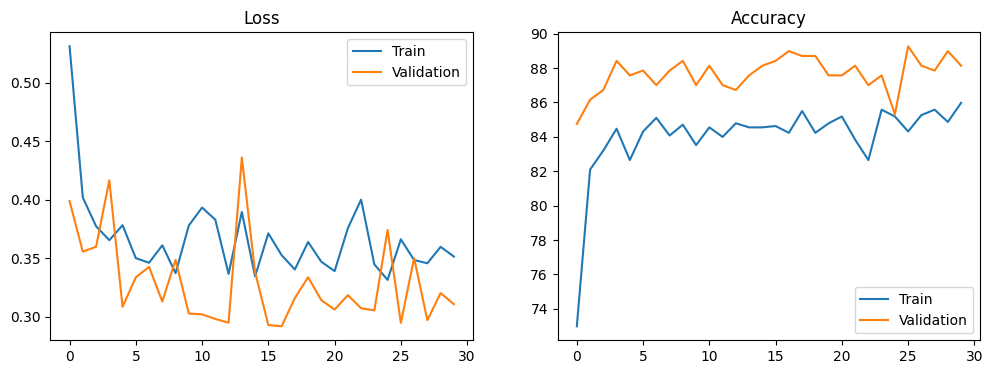

In [ ]:
plot_history(history)

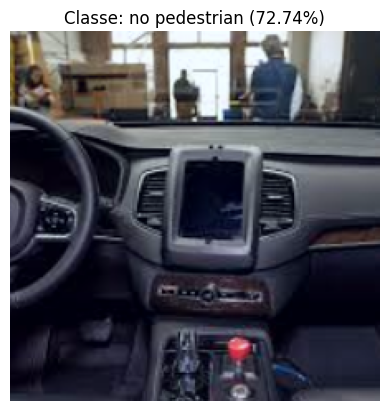

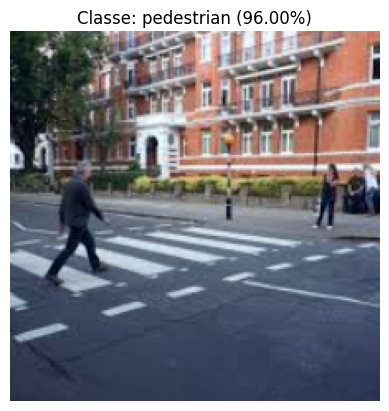

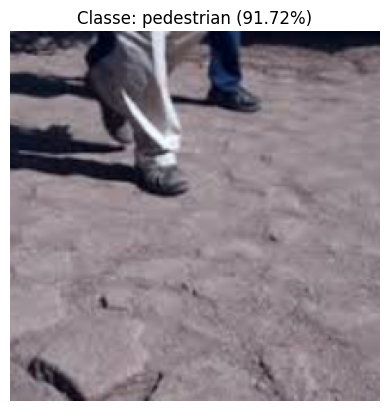

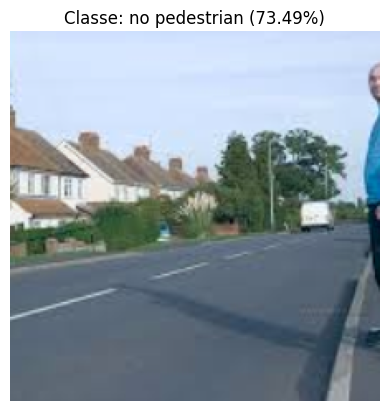

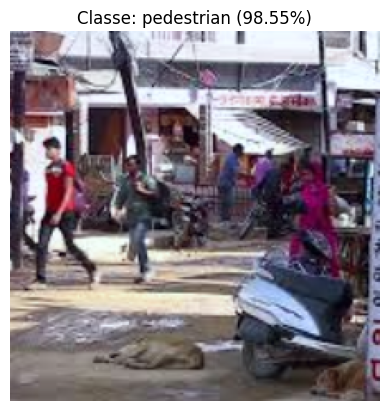

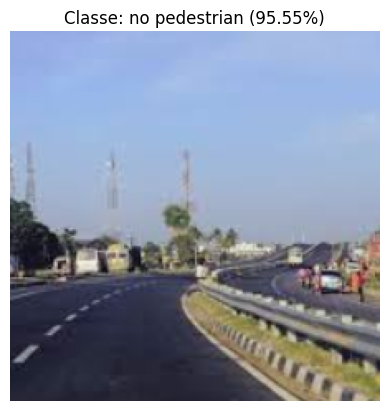

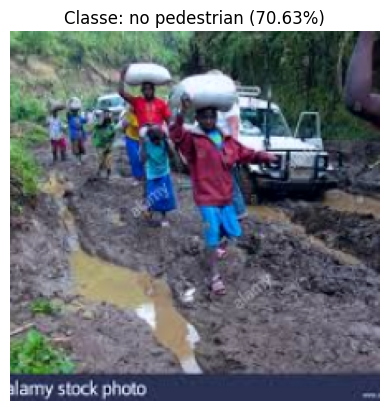

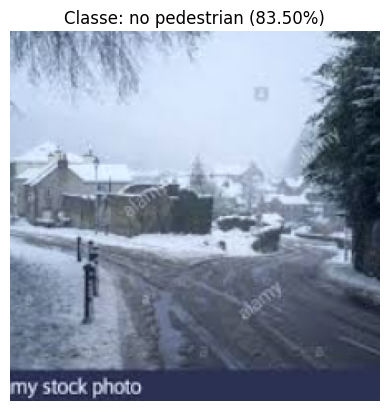

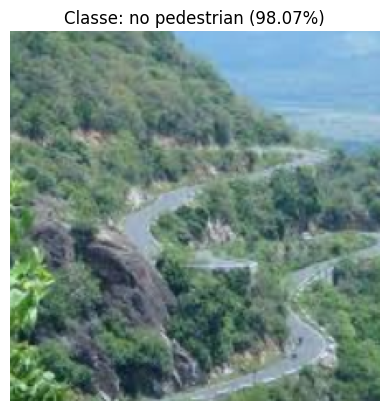

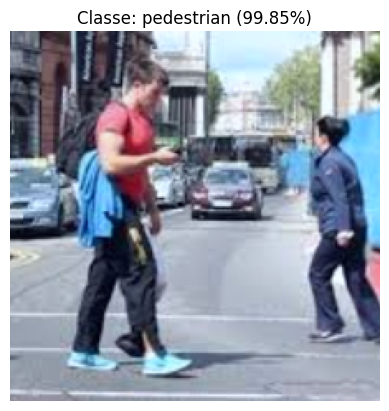

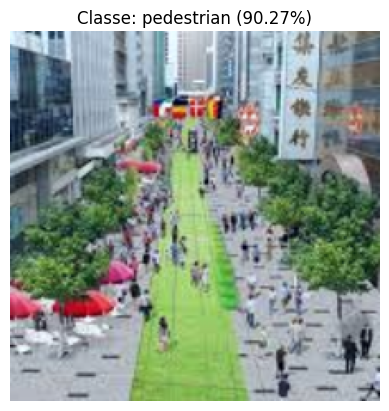

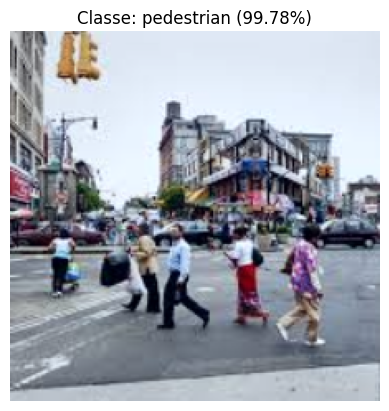

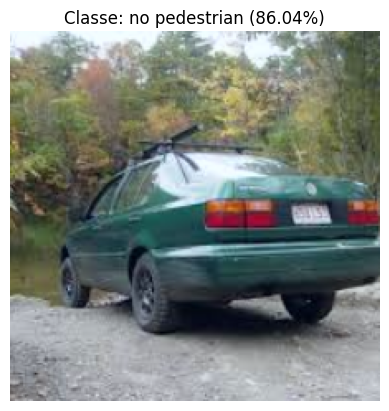

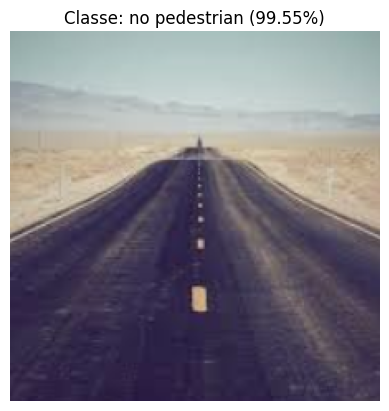

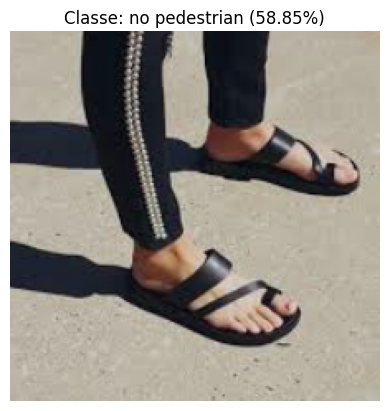

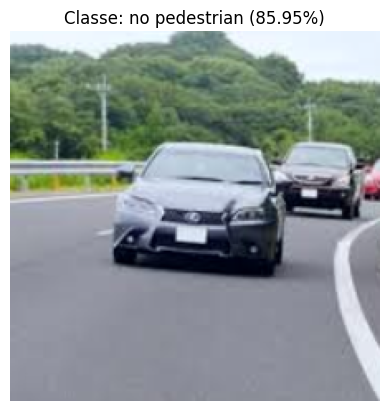

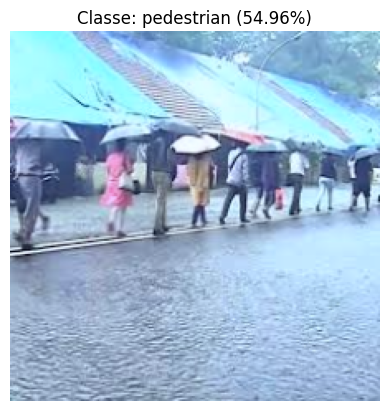

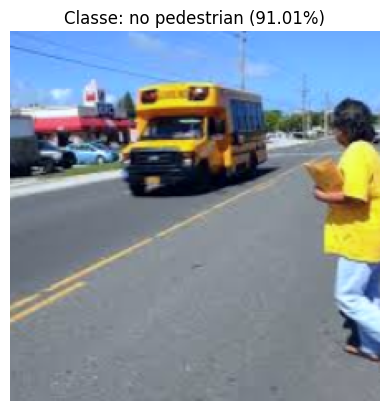

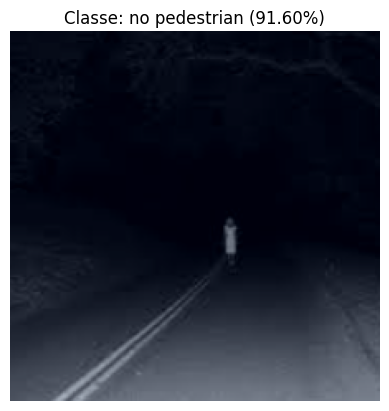

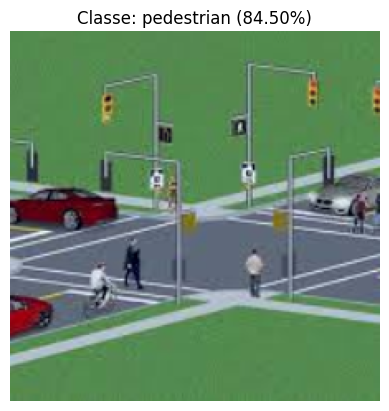

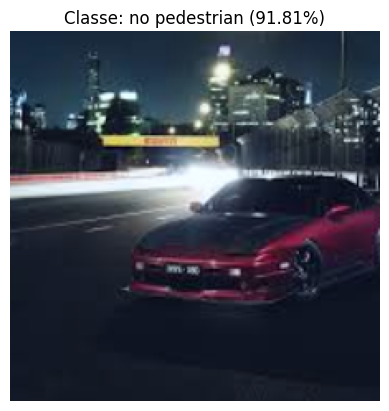

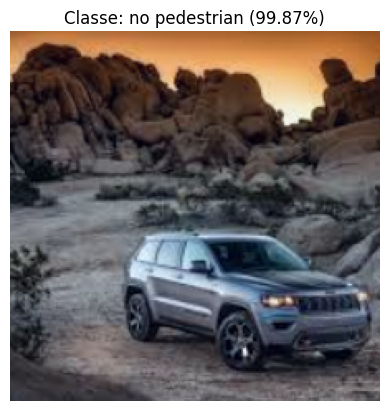

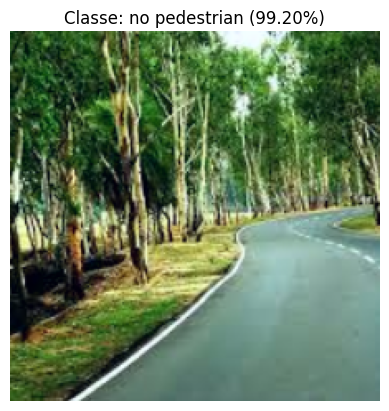

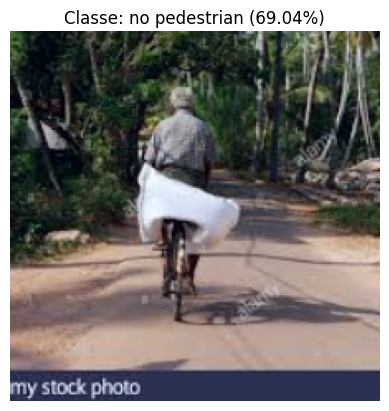

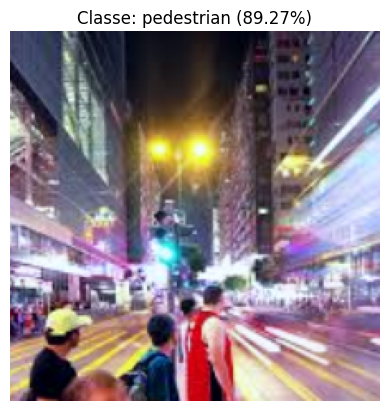

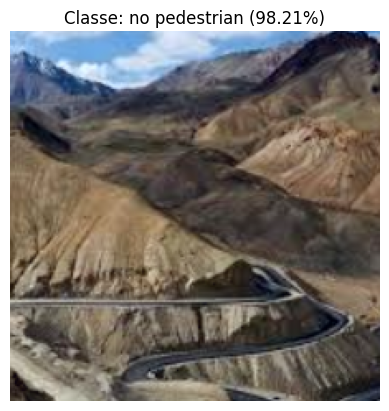

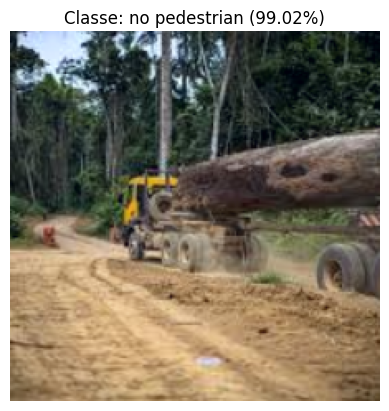

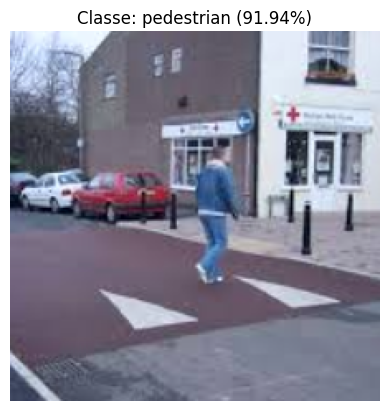

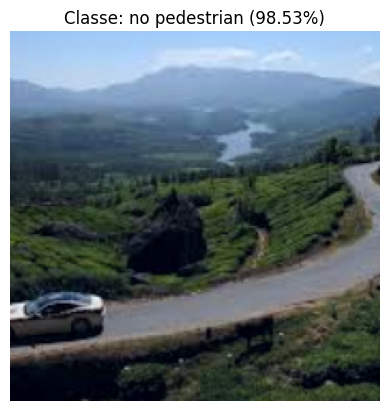

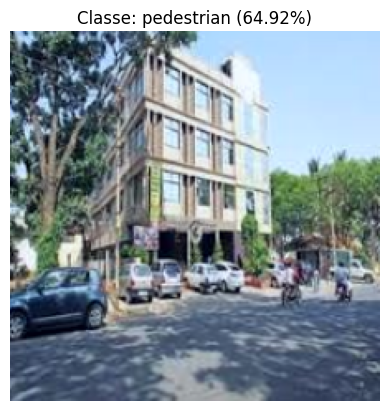

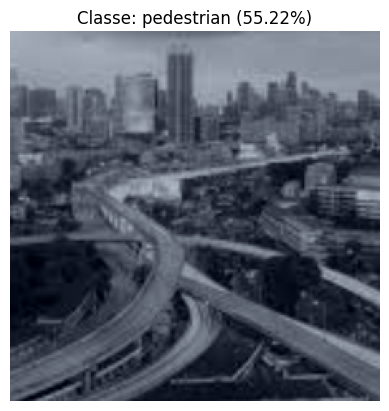

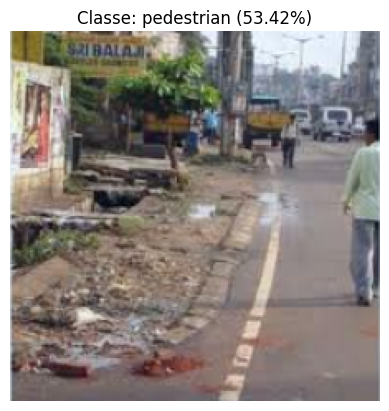

In [ ]:
# Certifique-se de que o dispositivo está configurado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Obtenha um batch de imagens e labels
images, labels = next(iter(val_loader))

# Faça a predição e plote para cada imagem
for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes, device)
